In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c
from scipy.optimize import newton

from astro530 import partition, saha_phi

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

### 17. Finding $P_e$ from $T$ and $P_g$

In [3]:
u_table = pd.read_table('./data/RepairedPartitionFunctions.txt', header=None, na_values='-', delim_whitespace=True)
u_table = u_table.set_index(0)

i_table = pd.read_table('./data/nist_ioniz.txt', header=None , delim_whitespace= True)
i_table = i_table.set_index(1)

In [4]:
A_table = pd.read_table('./data/SolarAbundance.txt', delim_whitespace= True)
A_table.dropna(inplace=True)

elements = A_table['element'].to_list()
elements.remove('Li')
elements.remove('Cs')

A_table = A_table.set_index('element')

#### (a)

In [5]:
def eq9_8(Pe, Pg, A_j, Phi_j):
    num = np.sum(A_j * (Phi_j/Pe) / (1 + Phi_j/Pe))
    denom = np.sum(A_j * (1 + (Phi_j/Pe) / (1 + Phi_j/Pe)))
    return Pg * num/denom

def iterate_Pe(Pe, Pg, A_j, Phi_j, tol=1e-8):
    diff = np.inf
    while diff > tol:
        Pe_new = eq9_8(Pe, Pg, A_j, Phi_j)
        diff = np.abs(Pe - Pe_new).value
        Pe = Pe_new
    return Pe

`iterate_Pe` takes an initial guess of $P_e$, as well as $P_g$ and an array of $A_j$ and $\Phi_j(T)$ for every element $j$ for which we have abundances, partition functions, and ionization energies. Starting at our intial guess it plugs $P_e$ into the RHS of Equation (9.8) $$P_e = P_g \frac{\sum A_j \frac{\Phi_j(T) /P_e}{1 + \Phi_j(T) /P_e}}{\sum A_j \left[1 + \frac{\Phi_j(T) /P_e}{1 + \Phi_j(T) /P_e}\right]}$$ 
We plug that new value of $P_e$ into the equation until the value converges. ($|{P_e}^{old} - {P_e}^{new}| <=$ some tolerance, which I set to be $10^{-8}$.

In [6]:
def P_e(T, log_Pg, A_table = A_table, elements = elements):
    '''
    Inputs:
        T - temperature
        log_Pg - gas pressure
    Output:
        electron pressure, as shown in Gray Eq. (9.8)
    '''
    
    Pg = 10 ** log_Pg * u.barye
    
    A_j = A_table.loc[elements]['A'].to_numpy()
    Phi_j = u.Quantity([saha_phi(element, T, i_table, u_table) for element in elements])
    Phi_H = saha_phi('H', T, i_table, u_table)
    
    if T > 30000:
        Pe_guess = 0.5 * P_g 
    else:
        Pe_guess = np.sqrt(Pg * Phi_H)
        
    P_e = iterate_Pe(Pe_guess, Pg, A_j, Phi_j)
    
    return P_e

`P_e` wraps `iterate_Pe`. It takes as input $T$, $\log P_g$, a table of abundances, and the list of elements that you want to include in the calculation of $P_e$. From those values, we can choose an initial guess for $P_e$

\begin{equation}
    P_e =
    \begin{cases} 
      (P_g \Phi_H(T))^{1/2} & T < 30000 K \\
      \frac{1}{2}P_g & T > 30000 K \\
   \end{cases}
\end{equation}

and then iterate to find the true value.

In [7]:
# calculate Pe for the values of T, Pg in Table 9.2 

T = np.array([4310, 4325, 4345, 4370, 4405, 4445, 4488, 4524, 4561, 4608, 4660, 4720, 4800, 4878, 
                   4995, 5132, 5294, 5490, 5733, 6043, 6429, 6904, 7467, 7962, 8358, 8630, 8811])
log_Pg = np.array([2.87, 3.03, 3.17, 3.29, 3.41, 3.52, 3.64, 3.75, 3.86, 3.97, 4.08, 4.19, 4.30, 4.41, 4.52, 4.63, 4.74, 
                   4.85, 4.95, 5.03, 5.10, 5.15, 5.18, 5.21, 5.23, 5.26, 5.29])

Pe_calc = u.Quantity([P_e(T[i], log_Pg[i]) for i in range(len(T))])
log_Pe_calc = np.log10(Pe_calc.value)

# and compare to Pe from Table 9.2
log_Pe = np.array([-1.16, -1.02, -0.89, -0.78, -0.66, -0.55, -0.44, -0.33, -0.23, -0.12, -0.01, 0.10, 0.22, 0.34, 0.47, 
                    0.61, 0.76, 0.93, 1.15, 1.43, 1.78, 2.18, 2.59, 2.92, 3.16, 3.32, 3.42])

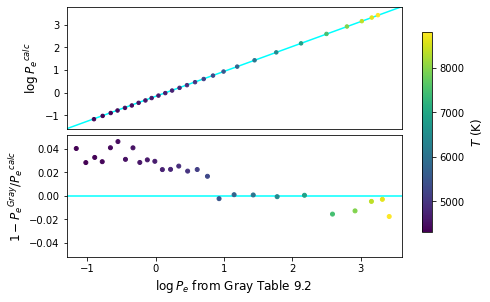

In [14]:
fig, axs = plt.subplots(2, 1, figsize = (7.5,4.6),  gridspec_kw = {'hspace': 0.05}) # gridspec_kw = {'wspace': 0.22, 'width_ratios':[7,8]})
ax1, ax2 = axs


diag = np.linspace(-1.6, 3.8)
ax1.plot(diag, diag, color ='cyan', zorder = 0)
ax1.scatter(log_Pe, log_Pe_calc, 12, T)
ax1.set_xticks([])
ax1.set_ylabel(r'$\log {P_e}^{calc}$')

sc = ax2.scatter(log_Pe, 1 - Pe_calc.value/10 **log_Pe, 16, T)
ax2.hlines(0, -1.3, 3.6, color ='cyan', zorder = 0)
ax2.set_ylim(-0.052, 0.052)
ax2.set_xlabel(r'$\log P_e$ from Gray Table 9.2')
ax2.set_ylabel('$1 - {P_e}^{Gray}/{P_e}^{calc}$')

fig.colorbar(sc, ax = axs, label = r'$T$ (K)', shrink=0.8)
plt.savefig('electron_P.png', bbox_inches='tight')

#### (c)

$$\sum_{Z\leq 30} A_j$$ $$\sum_{Z\leq 30} A_j \mu_j$$

In [9]:
lightest = A_table.iloc[0:30]
print(np.sum(lightest['A']))
print(np.sum(lightest['A'] * lightest['weight']))

1.0861752053727
1.3671076219525629


#### (d)
$$\sum_{Z > 2} A_j$$
$$\sum_{Z > 2} A_j \mu_j$$

In [10]:
metals = A_table.iloc[2:]
print(np.sum(metals['A']))
print(np.sum(metals['A'] * metals['weight']))

0.001075212672199
0.018453079261262224


In [173]:
#df = pd.DataFrame(np.transpose([T,log_Pg,log_Pe,log_Pe_calc]), columns=('T', 'Pg', 'Pe (Gray)', 'Pe (Calc)'))
#print(df.to_latex(index=False, formatters = ['{:.0f}'.format, '{:.2f}'.format, '{:.2f}'.format, '{:.2f}'.format], column_format='cccc'))